# 概述
这个项目的目的是实现通过对图片进行处理提取出图片中车牌号信息（实际生活中需处理视频，事实上也是把视频流转换为一帧又一帧的图） 主要分三个步骤，对应地是三个Python文件，分别是：

## 1.将图片中车牌区域提取出来，展示并保存（step1.py）
项目第一步，要把所给图片中的车牌区域提取出来，展示，并保存到./car_license/test.png  
前面的几个函数是展示处理后图片的函数，运行中想展示哪一步的图像都可以调用这三个函数展示图像。   
主要是载入图片、灰度处理、高斯滤波、sobel边缘检测、自适应阈值处理、闭运算、x轴腐蚀再膨胀，y轴膨胀再腐蚀、中值滤波、最后检测并绘制轮廓这些步骤，通过车牌轮廓外接长方形特有的长宽比特征筛选出车牌所在区域，最后保存和展示得到的车牌区域图片。   
保存好的图片将在第二步（step2.py）中用到。   
代码和运行结果如下，为了更好地展示每一步的操作结果，这部分代码在代码文件中代码的基础上添加了一些plt的方法展示几个关键步骤得到的图像。


最终结果如下：


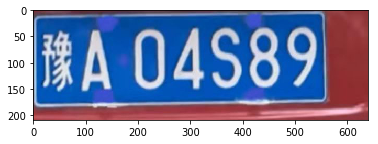

重要步骤得到的图片展示：


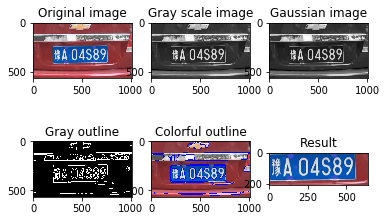

In [3]:
'''
本文件完成项目第一步，把所给图片中的车牌区域提取出来，展示，并保存到./car_license/test.png
前面的几个函数是展示处理后图片的函数，运行中想展示哪一步的图像都可以调用这三个函数展示图像
主要是载入图片、灰度处理、高斯滤波、sobel边缘检测、自适应阈值处理、闭运算、x轴腐蚀再膨胀，y轴膨胀再腐蚀、
中值滤波、最后检测并绘制轮廓这些步骤，最后保存和展示图片，保存好的图片将在第二步（step2.py）中用到
'''

#导入需要的工具包
import cv2
from matplotlib import pyplot as plt

#显示图片
def cv_show(name,img):
    cv2.imshow(name,img)
    cv2.waitKey()
    cv2.destroyAllWindows()

#展示彩色图片
def plt_show0(img):
    plt.imshow(img[:,:,[2,1,0]])
    plt.show()
    
#展示灰度图片
def plt_show1(img):
    plt.imshow(img, cmap = 'gray')
    plt.show()

#读取图片并转化为灰度图,彩图如下：
raw_car0 = cv2.imread('car0.png')

#灰度图如下：
car0 = cv2.cvtColor(raw_car0, cv2.COLOR_BGR2GRAY)


#高斯滤波去噪
gau = cv2.GaussianBlur(car0, (3,3), 0)


#利用sobel算子进行边缘检测
sobel_x = cv2.Sobel(gau, cv2.CV_16S, 1, 0)
absx = cv2.convertScaleAbs(sobel_x)
sobel_y = cv2.Sobel(gau, cv2.CV_16S, 0, 1)
absy = cv2.convertScaleAbs(sobel_y)
dst = cv2.addWeighted(absx, 0.5, absy, 0.5, 0)

#自适应阈值处理（把边缘检测后的图片转化为只有黑、白两种颜色的图片）
ret, dst = cv2.threshold(dst, 0, 255, cv2.THRESH_OTSU)

#闭运算（把白色部分连成一个整体）
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17,5))
car = cv2.morphologyEx(dst, cv2.MORPH_CLOSE, kernel, iterations = 1)


#去除小白点
kernelx = cv2.getStructuringElement(cv2.MORPH_RECT, (20,1))
kernely = cv2.getStructuringElement(cv2.MORPH_RECT, (1,19))

#X轴：膨胀再腐蚀
car = cv2.dilate(car,kernelx)
car = cv2.erode(car,kernelx)

#Y轴：腐蚀再膨胀
car = cv2.dilate(car,kernely)
car = cv2.erode(car,kernely)

#中值滤波(进一步去除噪音点)
car = cv2.medianBlur(car, 15)

#检测和画出轮廓
binary, contours, hierarchy = cv2.findContours(car, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
acar = raw_car0.copy() #复制图片并用此来画出轮廓，防止原图被修改保存
dcar = cv2.drawContours(acar, contours, -1, (255, 0, 0), 5)

#筛选出车牌位置（利用长宽比）
for item in contours:
    rect = cv2.boundingRect(item)
    x = rect[0]
    y = rect[1]
    weight = rect[2]
    height = rect[3]
    if (weight > (3*height)) and (weight < (4*height)):
        car = raw_car0[y:y+height, x:x+weight]
        #保存和展示图像
        cv2.imwrite('./car_license/test1.png',car)

#保存图片
show = cv2.imread('./car_license/test1.png')


#展示图片
print('最终结果如下：')
plt_show0(show)

print('重要步骤得到的图片展示：')
plt.subplot(231),plt.imshow(raw_car0[:,:,[2,1,0]]),plt.title('Original image')
plt.subplot(232),plt.imshow(car0, cmap = 'gray'),plt.title('Gray scale image')
plt.subplot(233),plt.imshow(gau, cmap = 'gray'),plt.title('Gaussian image')
plt.subplot(234),plt.imshow(dst, cmap = 'gray'),plt.title('Gray outline')
plt.subplot(235),plt.imshow(dcar[:,:,[2,1,0]]),plt.title('Colorful outline')
plt.subplot(236),plt.imshow(show[:,:,[2,1,0]]),plt.title('Result')
plt.show()

## 2.对第一步得到的图像进一步处理，将每个车牌号的字符图片分离出来，展示并保存（step2.py）   
项目的第二步需要对第一步得到的图像进一步处理，将每个车牌号的字符图片分离出来，展示并保存到./words这一文件夹。  
前面的几个函数是展示处理后图片的函数，运行中想展示哪一步的图像都可以调用这三个函数展示图像。  
一开始主要是载入图片、高斯去噪、灰度处理、自适应阈值处理、轮廓检测和画出轮廓这几步，对图像初步处理的思路大致和step1中相似，但在具体操作和参数设置上有很多不同，这些步骤设计和参数选择是我在不断实践中总结的一套比较合适的方法。  
后面则是筛选出各个字符位置的轮廓（利用长宽比），得到只含一个字符的图片七张，最后把图片保存到./words这一文件夹。  
代码和运行结果如下：


运行结果如下，7个字符被分为七张图：


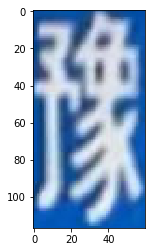

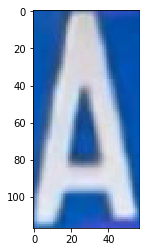

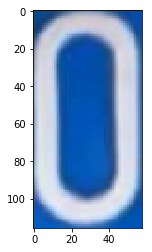

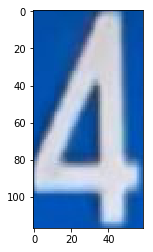

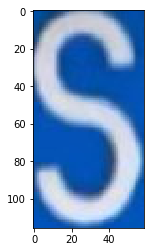

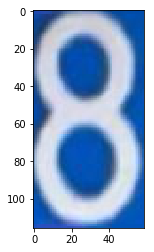

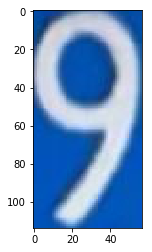

对图像的初步处理基本和step1类似，就不再展示前面具体的过程


In [6]:
'''
本文件是项目的第二步
需要对第一步得到的图像进一步处理，将每个车牌号的字符图片分离出来，展示并保存到./words这一文件夹
前面的几个函数是展示处理后图片的函数，运行中想展示哪一步的图像都可以调用这三个函数展示图像
一开始主要是载入图片、高斯去噪、灰度处理、自适应阈值处理、轮廓检测和画出轮廓这几步，
对图像初步处理的思路大致和step1中相似，但在具体操作和参数设置上有很多不同，
这些步骤设计和参数选择是我在不断实践中总结的一套比较合适的方法
后面则是筛选出各个字符位置的轮廓（利用长宽比），得到只含一个字符的图片七张，最后把图片保存到./words这一文件夹
'''

#导入需要的工具包
import os
import cv2
from matplotlib import pyplot as plt

#显示图片
def cv_show(name,img):
    cv2.imshow(name,img)
    cv2.waitKey()
    cv2.destroyAllWindows()

#展示彩色图片
def plt_show0(img):
    plt.imshow(img[:,:,[2,1,0]])
    plt.show()
 

#展示灰度图片
def plt_show1(img):
    plt.imshow(img, cmap = 'gray')
    plt.show()

#载入图片
raw_img = cv2.imread('./car_license/test.png')

#高斯去噪
gau = cv2.GaussianBlur(raw_img, (3,3), 0)

#灰度处理
gray_img = cv2.cvtColor(raw_img, cv2.COLOR_RGB2GRAY)

#自适应阈值处理,化为二值图像
ret, threshold = cv2.threshold(gray_img, 0, 255, cv2.THRESH_OTSU)

#计算二值图像黑白点的个数，防止遇到绿牌照，让车牌号一直为白色
area_white = 0
area_black = 0
height, width = threshold.shape
for i in range(height):
    for j in range(width):
        if threshold[i,j] == 255:
            area_white += 1
        else:
            area_black += 1

#如果本来白色区域大，进行颜色反转
if area_white > area_black:
    ret, threshold = cv2.threshold(gray_img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

#把字变胖，让一个字成为一个整体但不同字之间仍然相互独立
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
dilate = cv2.dilate(threshold, kernel)
#plt_show1(dilate)

#轮廓检测
binary, contours, hierarchy = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#画出轮廓
img1 = raw_img.copy()  #复制图片并用此来画出轮廓，防止原图被修改保存
cv2.drawContours(img1, contours, -1, (127, 127, 255), 5)
#plt_show0(img1)

#筛选出各字符位置的轮廓（采用长宽比1.7:1到3.5:1之间，因为‘1’这种数长宽比较大，我把一开始采用的范围扩大了）
words = []
for item in contours:
    word = []
    rect = cv2.boundingRect(item)
    x = rect[0]
    y = rect[1]
    weight = rect[2]
    height = rect[3]
    word.append(x)
    word.append(y)
    word.append(weight)
    word.append(height)
    words.append(word)

#升序排列
words = sorted(words, key = lambda a:a[0], reverse = False)

#print(words)

#存储每个字符的图片
i = 0
print('运行结果如下，7个字符被分为七张图：')
for word in words:
    if(word[3] > (word[2] * 1.7)) and (word[3] < (word[2] * 3.5)):
        i = i+1
        image = raw_img[word[1] : word[1] + word[3], word[0] : word[0] + word[2]]
        plt_show0(image)
        cv2.imwrite('./words/test_'+str(i)+'.png',image)
print('对图像的初步处理基本和step1类似，就不再展示前面具体的过程')

## 3.匹配模板，判断step2中得到图片的字符是什么并合并它们（step3.py）
第三步需要用到一些模板来对比判断图片中的字符。模板在./model文件夹中，有上万张样本图片，是我在网络上直接copy的大佬提供的模板。  
通过定义和调用一些对比模板的函数，找出./words中每个图（step2得到并保存的图）最匹配的字符，并把他们连接起来，就能得到图中的车牌号。  
我把匹配分为两步，第一步匹配汉字，第二步匹配后面的字母和数字，并在其中通过特殊的变量控制这两步的不同执行条件。
这一步因为需要和大量模板匹配，运行起来会比较慢，结果需耐心等待。  
代码和运行结果如下：

In [7]:
'''
第三步需要用到一些模板来对比判断图片中的字符。
模板在./model文件夹中，有上万张样本图片，是我在网络上直接copy的大佬提供的模板。  
通过定义和调用一些对比模板的函数，找出./words中每个图（step2得到并保存的图）最匹配的字符，
并把他们连接起来，就能得到图中的车牌号。  
我把匹配分为两步，第一步匹配汉字，第二步匹配后面的字母和数字，并在其中通过特殊的变量控制这两步的不同执行条件
这一步因为需要和大量模板匹配，运行起来会比较慢，结果需耐心等待
'''

#导入需要的工具包
import os
from unittest import result
import cv2
import numpy as np
from matplotlib import pyplot as plt

#显示图片
def cv_show(name,img):
    cv2.imshow(name,img)
    cv2.waitKey()
    cv2.destroyAllWindows()

#展示彩色图片
def plt_show0(img):
    plt.imshow(img[:,:,[2,1,0]])
    plt.show()
     

#展示灰度图片
def plt_show1(img):
    plt.imshow(img, cmap = 'gray')
    plt.show()

#索引磨板（车牌号没有I，因为容易和1混淆，同理没有O，因为容易和0混淆）
template = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
            'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 
            'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
            '藏', '川', '鄂', '甘', '赣', '贵', '桂', '黑', '沪', '吉', '冀', '津', '晋', '京', '辽', '鲁',
            '蒙', '闽', '宁', '青', '琼', '陕', '苏', '皖', '湘', '新', '渝', '豫', '粤', '云', '浙',]

#读取模板中所有图片的函数
def read(model_name):
    model_list = []
    for filename in os.listdir(model_name):
        model_list.append(model_name + '/' + filename)

    return model_list

#和中文匹配
c_words = []
for i in range(34, 64):
    c_word = read('./model/' + template[i])
    c_words.append(c_word)
k = 1

#定义一个处理图像并匹配车牌号的函数
def read_words(img_path):
    img = cv2.imread(img_path)
    gau = cv2.GaussianBlur(img, (3,3), 0)
    gray = cv2.cvtColor(gau, cv2.COLOR_RGB2GRAY)
    ret, im = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    best_score = []
    for c_word in c_words:
        score = []
        for word in c_word:
            template_img = cv2.imdecode(np.fromfile(word, dtype = np.uint8), 1)
            template_img = cv2.cvtColor(template_img, cv2.COLOR_RGB2GRAY)
            ret, template_img = cv2.threshold(template_img, 0, 255, cv2.THRESH_OTSU)
            height, width = template_img.shape
            image = im.copy()
            image = cv2.resize(image, (width, height))
            result = cv2.matchTemplate(image, template_img, cv2.TM_CCOEFF)
            score.append(result[0][0])
        best_score.append(max(score))
    if k == 1: #这个判断条件区分匹配汉字还是字母or数字
        return template[34 + (best_score.index(max(best_score)))]
    else:
        return template[(best_score.index(max(best_score)))]

#读取第一个汉字车牌号
a = (read_words('./words/test_1.png')) 
#在k=1时存储汉字字符的值到变量a中，此后将把k改为0，用于调用函数和字母、数字匹配

#和字母、数字匹配
c_words = []
for i in range(0, 34):
    c_word = read('./model/' + template[i])
    c_words.append(c_word)
k = 0

#把结果存储在result中
def show(i):
        return read_words('./words/test_'+str(i)+'.png')

result = a + show(2) +show(3) + show(4) +show(5) + show(6) + show(7)
print('车牌号是: ',result)

车牌号是:  豫A04S89
